In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = trainset.classes
print("Classes:", classes)

def get_model(model_name, num_classes=10):
    if model_name == "resnet":
        model = models.resnet50(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif model_name == "vit":
        model = models.vit_b_16(pretrained=True)
        in_features = model.heads.head.in_features
        model.heads.head = nn.Linear(in_features, num_classes)
    else:
        raise ValueError("Model not supported")
    return model.to(device)


def train_model(model, trainloader, testloader, epochs=5, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_acc_history, test_acc_history = [], []

    for epoch in range(epochs):
        model.train()
        running_corrects, running_loss = 0, 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            running_loss += loss.item() * inputs.size(0)

        epoch_acc = running_corrects / len(trainloader.dataset)
        train_acc_history.append(epoch_acc)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels).item()
                total += labels.size(0)

        test_acc = correct / total
        test_acc_history.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {epoch_acc:.4f}, Test Acc: {test_acc:.4f}")

    return model, train_acc_history, test_acc_history


resnet = get_model("resnet")
resnet, resnet_train_acc, resnet_test_acc = train_model(resnet, trainloader, testloader, epochs=5, lr=1e-4)
torch.save(resnet.state_dict(), "resnet_cifar10.pth")




Using device: cuda
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Epoch 1/5, Train Acc: 0.9109, Test Acc: 0.9369
Epoch 2/5, Train Acc: 0.9656, Test Acc: 0.9500
Epoch 3/5, Train Acc: 0.9777, Test Acc: 0.9500
Epoch 4/5, Train Acc: 0.9823, Test Acc: 0.9579
Epoch 5/5, Train Acc: 0.9867, Test Acc: 0.9524


Using device: cuda


/tmp/ipython-input-14142670.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # AMP scaler
/tmp/ipython-input-14142670.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-14142670.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():   # AMP in eval too


Epoch 1/5, Train Acc: 0.9135, Test Acc: 0.9363
Epoch 2/5, Train Acc: 0.9388, Test Acc: 0.9108
Epoch 3/5, Train Acc: 0.9502, Test Acc: 0.9400
Epoch 4/5, Train Acc: 0.9592, Test Acc: 0.9464
Epoch 5/5, Train Acc: 0.9650, Test Acc: 0.9441


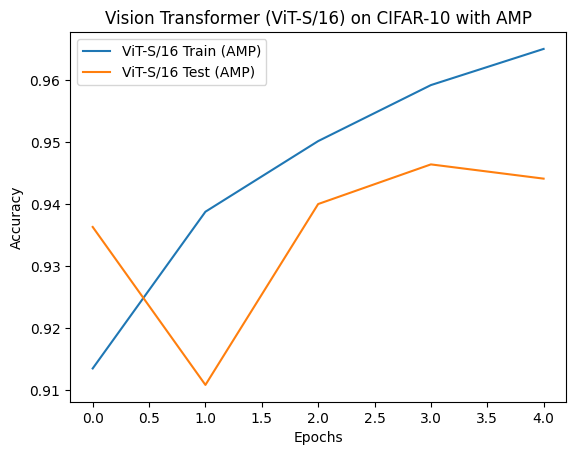

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)   # batch=8
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)


def get_vit(num_classes=10):
    model = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=num_classes)
    return model.to(device)


def train_model(model, trainloader, testloader, epochs=5, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    scaler = torch.cuda.amp.GradScaler()
    train_acc_history, test_acc_history = [], []

    for epoch in range(epochs):
        model.train()
        running_corrects = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()

        train_acc = running_corrects / len(trainloader.dataset)
        train_acc_history.append(train_acc)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels).item()
                total += labels.size(0)

        test_acc = correct / total
        test_acc_history.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return model, train_acc_history, test_acc_history


torch.cuda.empty_cache()
vit = get_vit()
vit, vit_train_acc, vit_test_acc = train_model(vit, trainloader, testloader, epochs=5, lr=1e-4)

torch.save(vit.state_dict(), "vit_s16_amp.pth")


plt.plot(vit_train_acc, label="ViT-S/16 Train (AMP)")
plt.plot(vit_test_acc, label="ViT-S/16 Test (AMP)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Vision Transformer (ViT-S/16) on CIFAR-10 with AMP")
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import timm
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("Upload your .pth files (resnet_cifar10.pth and vit_s16_amp.pth)")
uploaded = files.upload()

resnet_file = [name for name in uploaded.keys() if "resnet" in name][0]
vit_file = [name for name in uploaded.keys() if "vit" in name][0]


transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)


resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet.load_state_dict(torch.load(resnet_file, map_location=device))
resnet.to(device)
resnet.eval()

vit = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=10)
vit.load_state_dict(torch.load(vit_file, map_location=device))
vit.to(device)
vit.eval()


def evaluate_model(model, testloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    return correct / total


resnet_final_acc = evaluate_model(resnet, testloader)
vit_final_acc = evaluate_model(vit, testloader)

print(f"ResNet-50 In-Distribution Test Accuracy: {resnet_final_acc:.4f}")
print(f"ViT-S/16 In-Distribution Test Accuracy: {vit_final_acc:.4f}")


Using device: cuda
Upload your .pth files (resnet_cifar10.pth and vit_s16_amp.pth)


Saving resnet_cifar10.pth to resnet_cifar10.pth
Saving vit_s16_amp.pth to vit_s16_amp.pth


100%|██████████| 170M/170M [00:08<00:00, 20.8MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet-50 In-Distribution Test Accuracy: 0.9524
ViT-S/16 In-Distribution Test Accuracy: 0.9361


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import timm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform_test_color = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test_gray = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


testset_color = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test_color)
testset_gray = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test_gray)

testloader_color = DataLoader(testset_color, batch_size=32, shuffle=False, num_workers=2)
testloader_gray = DataLoader(testset_gray, batch_size=32, shuffle=False, num_workers=2)


resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet.load_state_dict(torch.load("resnet_cifar10.pth", map_location=device))
resnet.to(device)
resnet.eval()

vit = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=10)
vit.load_state_dict(torch.load("vit_s16_amp.pth", map_location=device))
vit.to(device)
vit.eval()


def evaluate_model(model, testloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    return correct / total


resnet_acc_color = evaluate_model(resnet, testloader_color)
resnet_acc_gray = evaluate_model(resnet, testloader_gray)

vit_acc_color = evaluate_model(vit, testloader_color)
vit_acc_gray = evaluate_model(vit, testloader_gray)

print("===== In-Distribution vs Grayscale Test Accuracy =====")
print(f"ResNet-50 Color: {resnet_acc_color:.4f}, Grayscale: {resnet_acc_gray:.4f}, Drop: {resnet_acc_color - resnet_acc_gray:.4f}")
print(f"ViT-S/16 Color: {vit_acc_color:.4f}, Grayscale: {vit_acc_gray:.4f}, Drop: {vit_acc_color - vit_acc_gray:.4f}")


Using device: cuda
===== In-Distribution vs Grayscale Test Accuracy =====
ResNet-50 Color: 0.9524, Grayscale: 0.8679, Drop: 0.0845
ViT-S/16 Color: 0.9361, Grayscale: 0.8678, Drop: 0.0683


Using device: cuda
ResNet-50 model loaded ✅
ViT-S/16 model loaded ✅

Visualizing ResNet predictions:


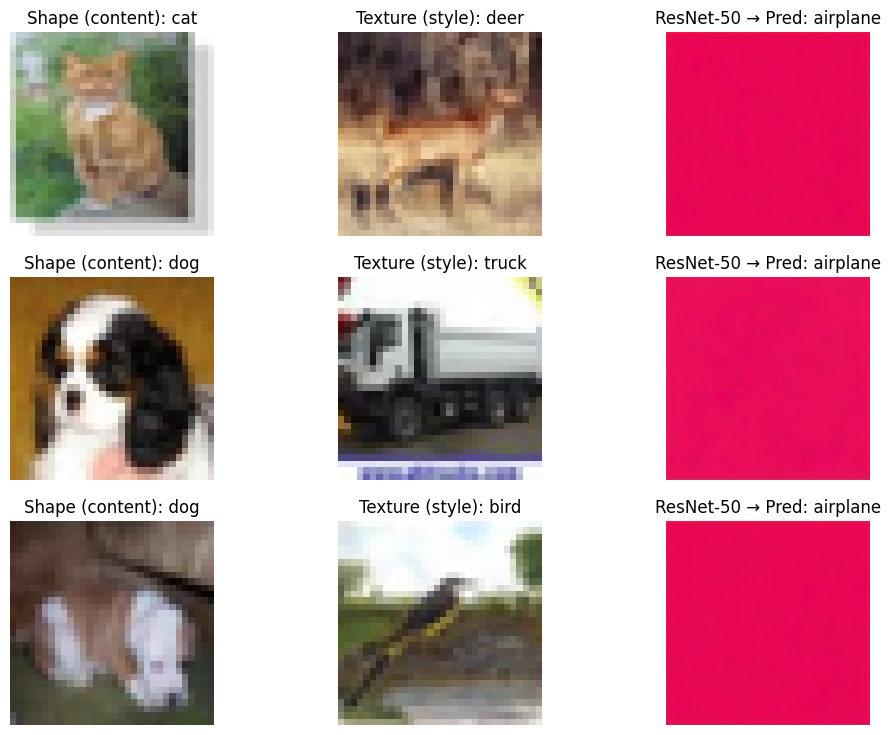


Visualizing ViT predictions:


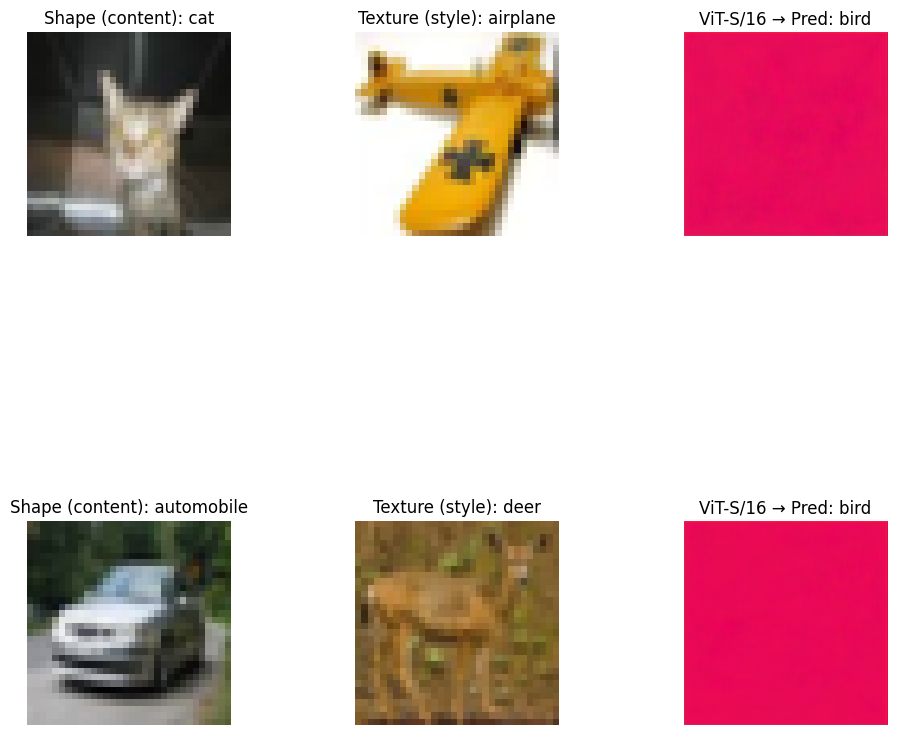


Shape Bias Results 🙌
ResNet-50 -> Shape Bias: 49.45% (45 shape vs 46 texture)
ViT-S/16 -> Shape Bias: 63.10% (53 shape vs 31 texture)


In [ ]:

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import timm
import random
import os
from PIL import Image
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


testset = datasets.CIFAR10(root="./data", train=False, download=True)
classes = testset.classes
print("CIFAR-10 classes:", classes)


def load_model_weights(model, path):
    checkpoint = torch.load(path, map_location=device)
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    model.load_state_dict(state_dict)
    return model

resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = load_model_weights(resnet, "resnet_cifar10.pth")
resnet.to(device).eval()
print("ResNet-50 model loaded ✅")

vit = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=10)
vit = load_model_weights(vit, "vit_s16_amp.pth")
vit.to(device).eval()
print("ViT-S/16 model loaded ✅")


cifar_norm = transforms.Normalize((0.5, 0.5, 0.5),
                                  (0.5, 0.5, 0.5))


class VGGEncoder(nn.Module):
    def __init__(self, vgg):
        super().__init__()
        self.enc_layers = nn.Sequential(*list(vgg.children())[:31])
    def forward(self, x):
        return self.enc_layers(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Identity()
    def forward(self, x):
        return self.model(x)

vgg = models.vgg19(pretrained=True).features.to(device).eval()
vgg_enc = VGGEncoder(vgg).to(device).eval()
decoder = Decoder().to(device).eval()


def adain(content_feat, style_feat, eps=1e-5):
    c_mean, c_std = content_feat.mean([2, 3], keepdim=True), content_feat.std([2, 3], keepdim=True) + eps
    s_mean, s_std = style_feat.mean([2, 3], keepdim=True), style_feat.std([2, 3], keepdim=True) + eps
    normalized = (content_feat - c_mean) / c_std
    return normalized * s_std + s_mean

def vgg_adain_style_transfer(content_img, style_img, alpha=1.0):
    vgg_tf = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    c = vgg_tf(content_img).unsqueeze(0).to(device)
    s = vgg_tf(style_img).unsqueeze(0).to(device)

    with torch.no_grad():
        c_feat = vgg_enc(c)
        s_feat = vgg_enc(s)
        t = adain(c_feat, s_feat)
        t = alpha * t + (1 - alpha) * c_feat
        stylized = decoder(t).cpu().squeeze(0)

    stylized = (stylized - stylized.min()) / (stylized.max() - stylized.min() + 1e-5)
    return stylized


def prepare_for_model(stylized_tensor):
    img_in = cifar_norm(stylized_tensor)
    img_in = img_in.unsqueeze(0).to(device)
    return img_in

def evaluate_shape_bias(model, n_samples=50):
    shape_correct, texture_correct = 0, 0

    for _ in range(n_samples):
        sample1 = random.choice(testset)
        sample2 = random.choice(testset)
        if sample1[1] == sample2[1]:
            continue

        content_img, shape_label = sample1
        style_img, texture_label = sample2
        stylized = vgg_adain_style_transfer(content_img, style_img)

        img_in = prepare_for_model(stylized)

        with torch.no_grad():
            pred = model(img_in).argmax(1).item()

        if pred == shape_label:
            shape_correct += 1
        elif pred == texture_label:
            texture_correct += 1

    shape_bias = 100.0 * shape_correct / (shape_correct + texture_correct + 1e-5)
    return shape_bias, shape_correct, texture_correct


resnet_bias, r_shape, r_texture = evaluate_shape_bias(resnet, n_samples=500)
vit_bias, v_shape, v_texture = evaluate_shape_bias(vit, n_samples=500)

print("\nShape Bias Results 🙌")
print(f"ResNet-50 -> Shape Bias: {resnet_bias:.2f}% ({r_shape} shape vs {r_texture} texture)")
print(f"ViT-S/16 -> Shape Bias: {vit_bias:.2f}% ({v_shape} shape vs {v_texture} texture)")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision import datasets, models
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import timm
import os




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

testset = datasets.CIFAR10(root="./data", train=False, download=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)
classes = testset.classes


preprocess = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])


def prepare_shifted_tensor(pil_img, dx, dy):
    img_resized = TF.resize(pil_img, (224, 224))
    shifted = TF.affine(
        img_resized,
        angle=0.0,
        translate=(int(dx), int(dy)),
        scale=1.0,
        shear=(0.0, 0.0),
        interpolation=Image.BILINEAR,
        fill=0
    )
    x = preprocess(shifted)
    return x


shifts = [
    (0,0), (4,0), (-4,0), (0,4), (0,-4), (8,0), (0,8)
]


def load_model_weights(model, path):
    checkpoint = torch.load(path, map_location=device)
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    model.load_state_dict(state_dict)
    return model

resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = load_model_weights(resnet, "resnet_cifar10.pth")
resnet.to(device).eval()

vit = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=10)
vit = load_model_weights(vit, "vit_s16_amp.pth")
vit.to(device).eval()


def batch_predict(model, imgs_tensor):
    model.eval()
    with torch.no_grad():
        logits = model(imgs_tensor.to(device))
        probs = F.softmax(logits, dim=1)
        confs, preds = probs.max(dim=1)
    return preds.cpu().numpy(), confs.cpu().numpy()

def evaluate_model_shifts(model, model_name="model"):
    print(f"\nComputing baseline predictions for {model_name} ...")
    baseline_preds_m = []
    baseline_confs_m = []

    for pil_img, label in tqdm(testset, total=len(testset)):
        x = preprocess(pil_img).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(x)
            probs = F.softmax(out, dim=1)
            conf, pred = probs.max(dim=1)
        baseline_preds_m.append(int(pred.item()))
        baseline_confs_m.append(float(conf.item()))

    baseline_preds_m = np.array(baseline_preds_m)
    baseline_confs_m = np.array(baseline_confs_m)

    summary = []
    for dx, dy in shifts:
        correct = 0
        same_pred = 0
        total = 0
        conf_drop_sum = 0.0

        for i, (pil_img, label) in enumerate(testset):
            x_shift = prepare_shifted_tensor(pil_img, dx, dy).unsqueeze(0).to(device)
            with torch.no_grad():
                out = model(x_shift)
                probs = F.softmax(out, dim=1)
                conf, pred = probs.max(dim=1)
            pred = int(pred.item())
            conf = float(conf.item())
            if pred == label: correct += 1
            if pred == baseline_preds_m[i]: same_pred += 1
            conf_drop_sum += (baseline_confs_m[i] - conf)
            total += 1

        acc = correct / total
        consistency = same_pred / total
        avg_conf_drop = conf_drop_sum / total

        summary.append({
            "dx": dx, "dy": dy,
            "accuracy": acc,
            "consistency": consistency,
            "avg_conf_drop": avg_conf_drop
        })

    return summary


resnet_shift_stats = evaluate_model_shifts(resnet, "ResNet-50")
vit_shift_stats = evaluate_model_shifts(vit, "ViT-S/16")


import pandas as pd
print("\nResNet shift results:")
display(pd.DataFrame(resnet_shift_stats))
print("\nViT shift results:")
display(pd.DataFrame(vit_shift_stats))


Using device: cuda

Computing baseline predictions for ResNet-50 ...


  0%|          | 0/10000 [00:00<?, ?it/s]


Computing baseline predictions for ViT-S/16 ...


  0%|          | 0/10000 [00:00<?, ?it/s]


ResNet shift results:


,dx,dy,accuracy,consistency,avg_conf_drop
0,0,0,0.9524,1.0000,0.000000
1,4,0,0.9514,0.9831,0.002331
2,-4,0,0.9493,0.9825,0.000796
3,0,4,0.9522,0.9824,0.000526
4,0,-4,0.9508,0.9807,0.001505
5,8,0,0.9506,0.9804,0.003108
6,0,8,0.9517,0.9809,0.001683



ViT shift results:


,dx,dy,accuracy,consistency,avg_conf_drop
0,0,0,0.9361,1.0000,0.000000
1,4,0,0.9343,0.9645,0.000834
2,-4,0,0.9337,0.9637,0.001676
3,0,4,0.9356,0.9650,-0.000003
4,0,-4,0.9344,0.9618,0.001488
5,8,0,0.9323,0.9553,0.002355
6,0,8,0.9349,0.9556,0.000526


Using device: cuda


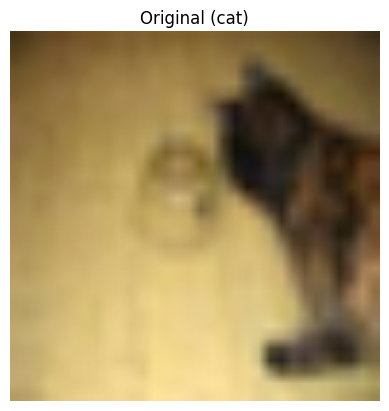

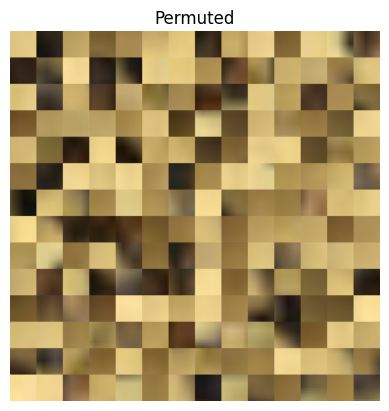

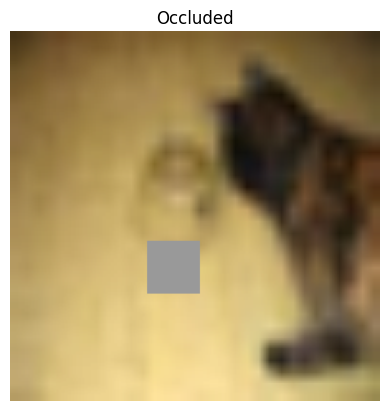


ResNet-50:
Original -> cat (1.00)
Permuted -> bird (0.70)
Occluded -> cat (0.99)

ViT-S/16:
Original -> cat (0.98)
Permuted -> cat (0.73)
Occluded -> cat (0.98)


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import numpy as np
from torchvision import datasets, models
import timm
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


testset = datasets.CIFAR10(root="./data", train=False, download=True)
classes = testset.classes


def load_model_weights(model, path):
    checkpoint = torch.load(path, map_location=device)
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    model.load_state_dict(state_dict)
    return model

resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = load_model_weights(resnet, "resnet_cifar10.pth")
resnet.to(device).eval()

vit = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=10)
vit = load_model_weights(vit, "vit_s16_amp.pth")
vit.to(device).eval()

to_tensor = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

def show(img, title=""):
    img = img.permute(1,2,0).cpu().numpy()
    img = (img - img.min()) / (img.max()-img.min() + 1e-5)
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


def permute_patches(img, patch_size=16):
    c,h,w = img.shape
    patches = []
    for i in range(0,h,patch_size):
        for j in range(0,w,patch_size):
            patch = img[:, i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    random.shuffle(patches)
    new_img = torch.zeros_like(img)
    idx = 0
    for i in range(0,h,patch_size):
        for j in range(0,w,patch_size):
            new_img[:, i:i+patch_size, j:j+patch_size] = patches[idx]
            idx += 1
    return new_img

def occlude_patch(img, patch_size=32):
    c,h,w = img.shape
    x = random.randint(0, h-patch_size)
    y = random.randint(0, w-patch_size)
    occluded = img.clone()
    occluded[:, x:x+patch_size, y:y+patch_size] = 0.0
    return occluded


def test_example(model, img, label, transform=True):
    if transform:
        x = to_tensor(img).unsqueeze(0).to(device)
    else:
        x = img.unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)
        probs = F.softmax(out, dim=1)
        conf, pred = probs.max(1)
    return pred.item(), conf.item()


idx = random.randint(0, len(testset)-1)
orig_img, true_label = testset[idx]
orig = to_tensor(orig_img)

perm = permute_patches(orig.clone())
occl = occlude_patch(orig.clone())

show(orig.clone(), f"Original ({classes[true_label]})")
show(perm.clone(), "Permuted")
show(occl.clone(), "Occluded")

for name, model in [("ResNet-50", resnet), ("ViT-S/16", vit)]:
    pred_o, conf_o = test_example(model, orig_img, true_label)
    pred_p, conf_p = test_example(model, perm, true_label, transform=False)
    pred_c, conf_c = test_example(model, occl, true_label, transform=False)

    print(f"\n{name}:")
    print(f"Original -> {classes[pred_o]} ({conf_o:.2f})")
    print(f"Permuted -> {classes[pred_p]} ({conf_p:.2f})")
    print(f"Occluded -> {classes[pred_c]} ({conf_c:.2f})")


Using device: cuda


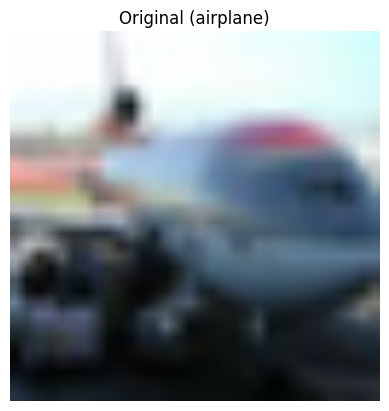

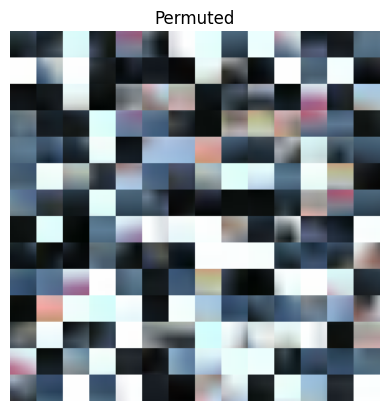

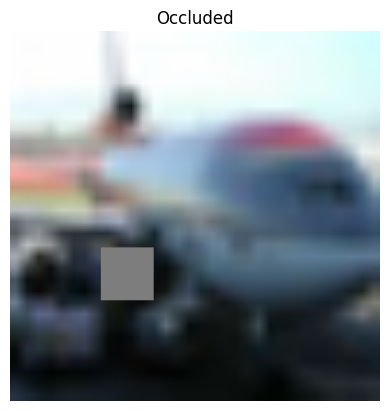


ResNet-50:
Original -> airplane (1.00)
Permuted -> bird (1.00)
Occluded -> airplane (1.00)

ViT-S/16:
Original -> airplane (0.97)
Permuted -> cat (0.48)
Occluded -> airplane (0.97)


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import numpy as np
from torchvision import datasets, models
import timm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

testset = datasets.CIFAR10(root="./data", train=False, download=True)
classes = testset.classes

def load_model_weights(model, path):
    checkpoint = torch.load(path, map_location=device)
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    model.load_state_dict(state_dict)
    return model

resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = load_model_weights(resnet, "resnet_cifar10.pth")
resnet.to(device).eval()

vit = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=10)
vit = load_model_weights(vit, "vit_s16_amp.pth")
vit.to(device).eval()

to_tensor = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

def show(img, title=""):
    img = img.permute(1,2,0).cpu().numpy()
    img = (img - img.min()) / (img.max()-img.min() + 1e-5)
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

def permute_patches(img, patch_size=16):
    c,h,w = img.shape
    patches = []
    for i in range(0,h,patch_size):
        for j in range(0,w,patch_size):
            patch = img[:, i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    random.shuffle(patches)
    new_img = torch.zeros_like(img)
    idx = 0
    for i in range(0,h,patch_size):
        for j in range(0,w,patch_size):
            new_img[:, i:i+patch_size, j:j+patch_size] = patches[idx]
            idx += 1
    return new_img

def occlude_patch(img, patch_size=32):
    c,h,w = img.shape
    x = random.randint(0, h-patch_size)
    y = random.randint(0, w-patch_size)
    occluded = img.clone()
    occluded[:, x:x+patch_size, y:y+patch_size] = 0.0
    return occluded

def test_example(model, img, label, transform=True):
    if transform:
        x = to_tensor(img).unsqueeze(0).to(device)
    else:
        x = img.unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)
        probs = F.softmax(out, dim=1)
        conf, pred = probs.max(1)
    return pred.item(), conf.item()

idx = random.randint(0, len(testset)-1)
orig_img, true_label = testset[idx]
orig = to_tensor(orig_img)

perm = permute_patches(orig.clone())
occl = occlude_patch(orig.clone())

show(orig.clone(), f"Original ({classes[true_label]})")
show(perm.clone(), "Permuted")
show(occl.clone(), "Occluded")

for name, model in [("ResNet-50", resnet), ("ViT-S/16", vit)]:
    pred_o, conf_o = test_example(model, orig_img, true_label)
    pred_p, conf_p = test_example(model, perm, true_label, transform=False)
    pred_c, conf_c = test_example(model, occl, true_label, transform=False)

    print(f"\n{name}:")
    print(f"Original -> {classes[pred_o]} ({conf_o:.2f})")
    print(f"Permuted -> {classes[pred_p]} ({conf_p:.2f})")
    print(f"Occluded -> {classes[pred_c]} ({conf_c:.2f})")


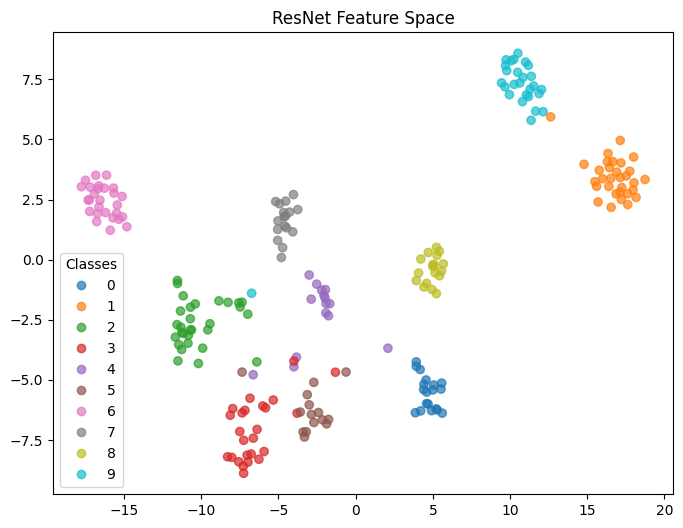

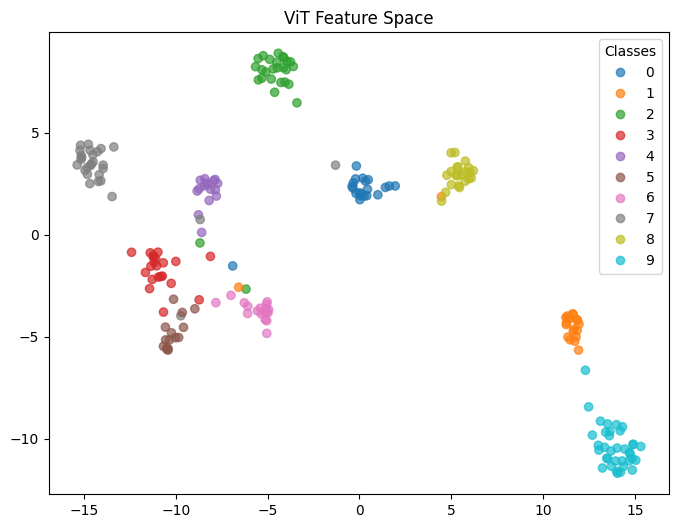

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import timm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_resnet(path):
    model = models.resnet50(num_classes=10)
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    return model.to(device).eval()

def load_vit(path):
    model = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=10)
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    return model.to(device).eval()

resnet = load_resnet("resnet_cifar10.pth")
vit = load_vit("vit_s16_amp.pth")

transform = transforms.Compose([
    transforms.Resize((224,224)),   # resize for both ResNet & ViT
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
dataloader = DataLoader(testset, batch_size=32, shuffle=True)


resnet_feat_extractor = nn.Sequential(*list(resnet.children())[:-1])
resnet_feat_extractor.eval().to(device)

def get_vit_features(model, imgs):
    with torch.no_grad():
        outputs = model.forward_features(imgs.to(device))
        return outputs[:, 0, :]


def extract_features(model_type, model, dataloader, n_samples=200):
    features, labels = [], []
    count = 0
    for imgs, labs in dataloader:
        if count >= n_samples:
            break
        imgs, labs = imgs.to(device), labs.to(device)

        if model_type == "resnet":
            with torch.no_grad():
                feat = resnet_feat_extractor(imgs).squeeze(-1).squeeze(-1)
        elif model_type == "vit":
            with torch.no_grad():
                feat = get_vit_features(model, imgs)

        features.append(feat.cpu().numpy())
        labels.append(labs.cpu().numpy())
        count += len(imgs)
    return np.vstack(features), np.hstack(labels)

def reduce_and_plot(features, labels, title="Feature Space"):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap="tab10", alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.show()


resnet_feats, resnet_labels = extract_features("resnet", resnet, dataloader, n_samples=200)
vit_feats, vit_labels = extract_features("vit", vit, dataloader, n_samples=200)

reduce_and_plot(resnet_feats, resnet_labels, "ResNet Feature Space")
reduce_and_plot(vit_feats, vit_labels, "ViT Feature Space")
